In [265]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Problem 1

In [266]:
case_data = pd.read_excel("Case Data.xlsx", sheet_name = 'Case Data')
count_data = pd.read_excel("Case Data.xlsx", sheet_name = 'Total Active Cases')

In [267]:
result_1 = case_data.merge(count_data['Date as of'], how = 'cross')
result_1 = result_1[result_1['Date as of'].between(result_1['Case Start'], result_1['Case End'])]
problem_1 = pd.merge(count_data['Date as of'],result_1.groupby('Date as of').size().reset_index(),
                     how ='left', on = 'Date as of').fillna(0).rename(columns={0:'Active Cases'})

In [268]:
problem_1

,Date as of,Active Cases
0,2018-10-21,1.0
1,2018-11-20,7.0
2,2018-12-20,5.0
3,2019-01-19,6.0
4,2019-02-18,6.0
5,2019-03-20,7.0
6,2019-04-19,9.0
7,2019-05-19,5.0
8,2019-06-18,11.0
9,2019-07-18,7.0


### Problem 2

#### EDA

In [269]:
reg_data = pd.read_excel("Reg Data.xlsx", sheet_name = 'Sheet1')

In [135]:
reg_data.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,y
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,33.784447,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.151639,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,1.339487,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,28.271293,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,35.441574,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,41.093217,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,47.782916,50.000000


Doesn't seem to be any null value in any of the columns

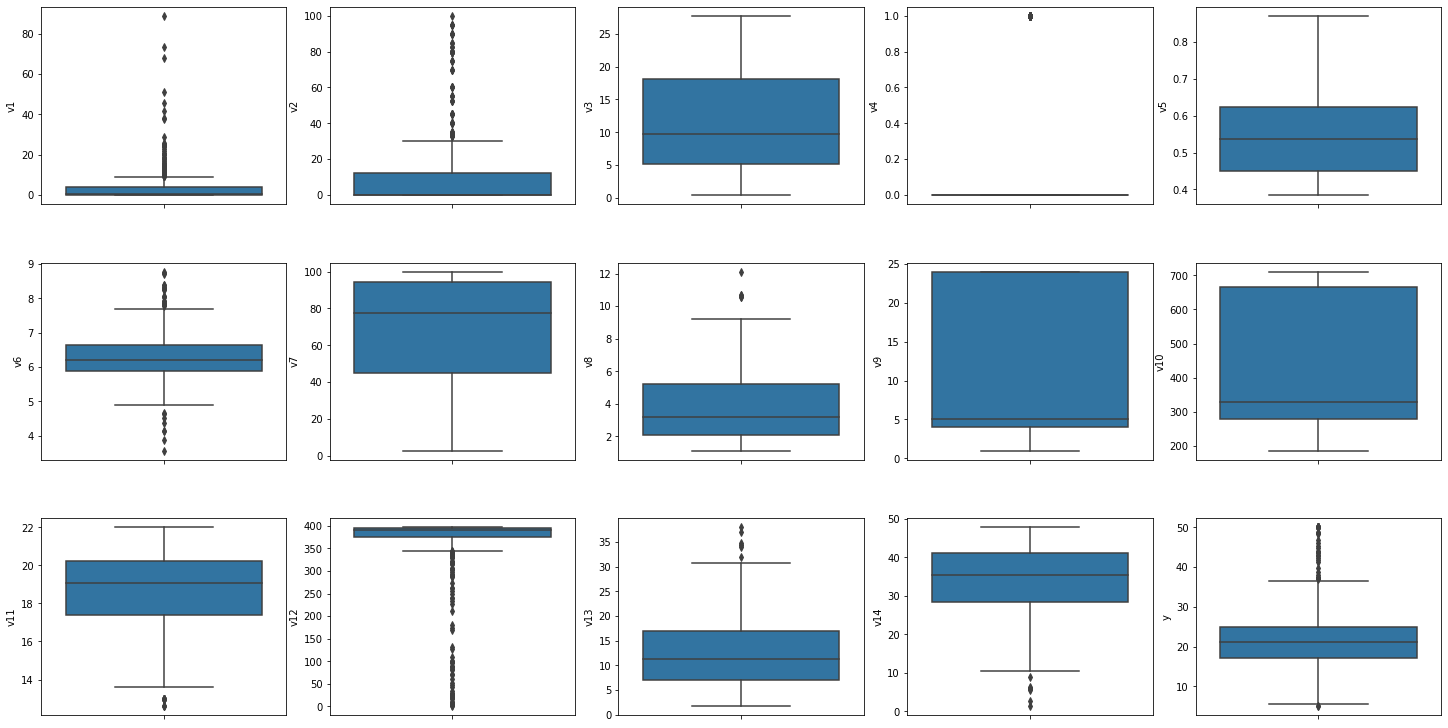

In [136]:
# Box plots to identify Outliers.
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in reg_data.items():
    sns.boxplot(y=k, data=reg_data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=5.0)

We can see their are outliers in y, and some variables like v2,v1,v6 and others. Removing all the outlier will underfit the model, but probably needs to take care of outliers in y. Let's also quickly look at distribution of these vars.

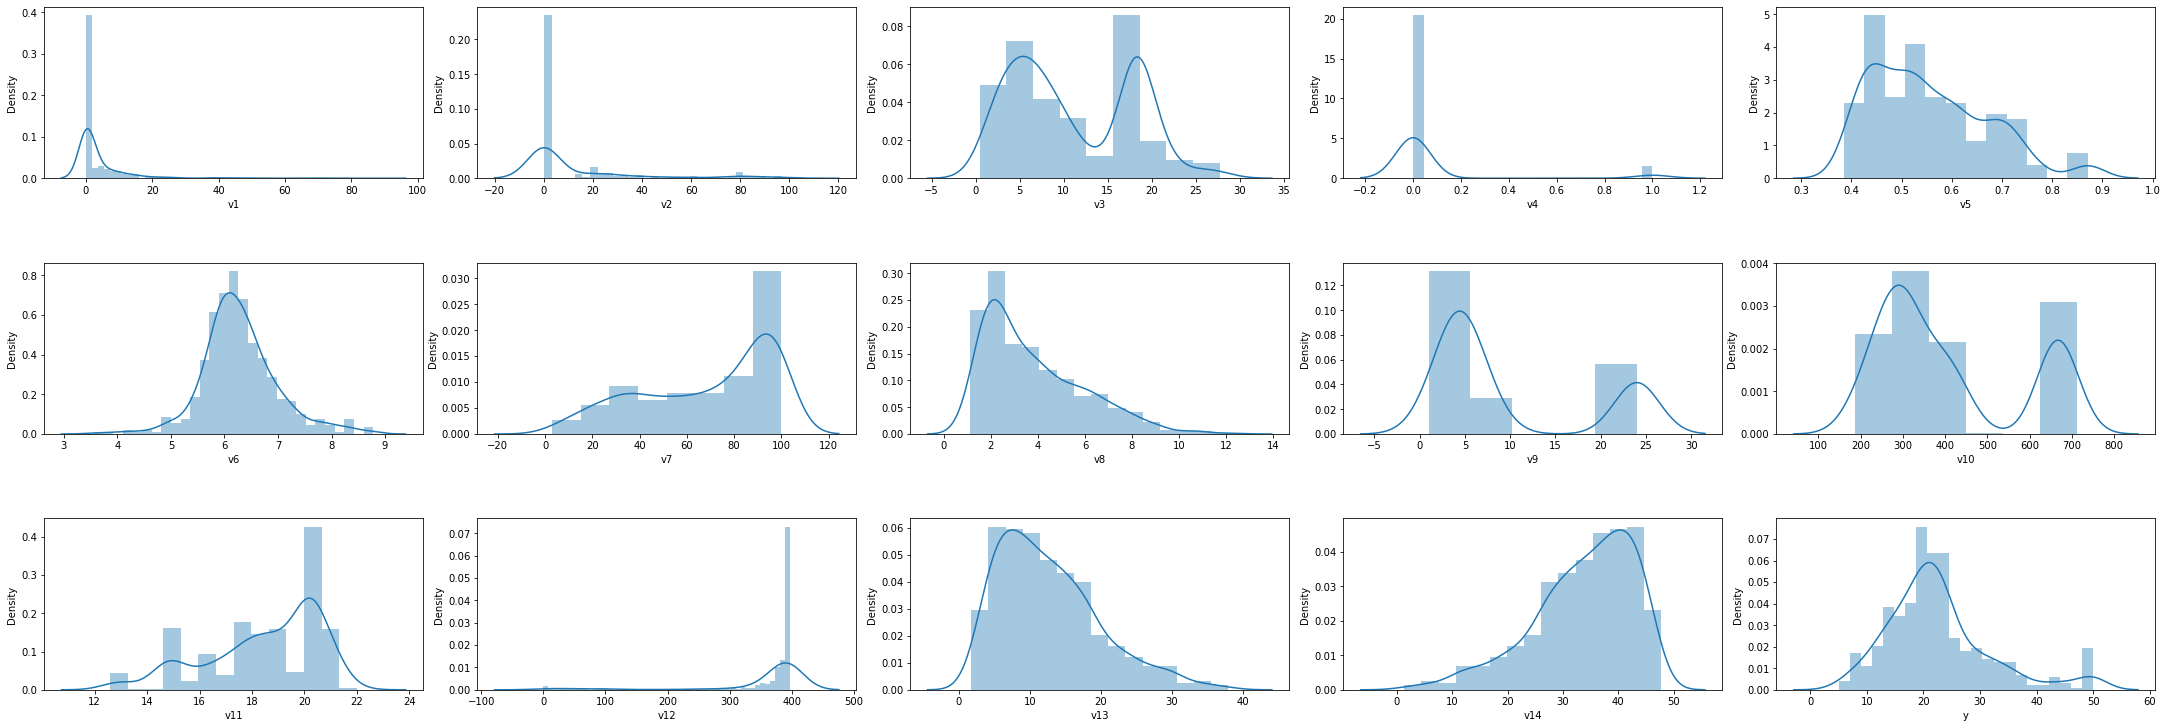

In [137]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(30, 10))
index = 0
axs = axs.flatten()
for k,v in reg_data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.3, w_pad=0.3, h_pad=5.0)

We can note that a lot of this variables are skewed hence a log transformation will help. Also v13 and v14 are looking like mirror image.

<AxesSubplot:>

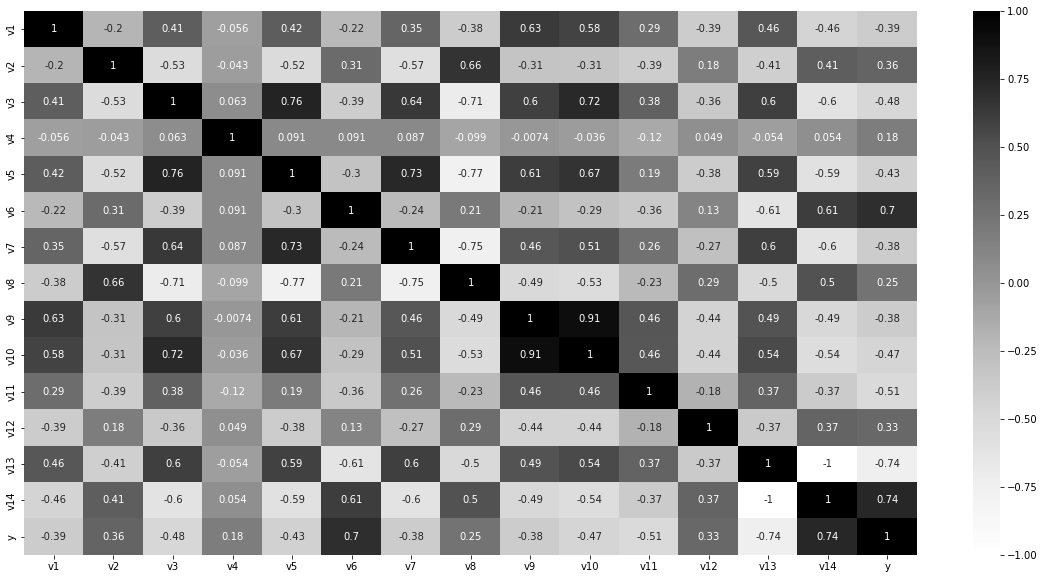

In [138]:
plt.figure(figsize=(20, 10))
sns.heatmap(reg_data.corr(),  annot=True,cmap='Greys')

Few things to observe
- We can see that var13 and var14 have correlation of -1, let's drop v 14 and proceed ahead
- v6 and v13 are having high correlation with y
- V9 and v10 are highly correlated and we should take one of the 2 based on correlation with y, same for v7 and v8

let's dig in some of the high correlated var

In [270]:
reg_data.drop(columns = ['v14'], inplace = True, axis = 1)

#### Feature engg

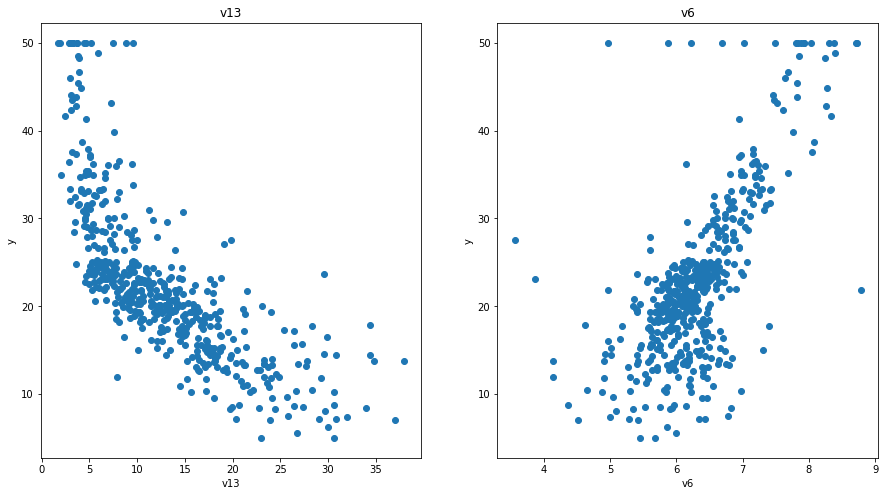

In [161]:
plt.figure(figsize=(15, 8))
features = ['v13', 'v6']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = reg_data[col]
    y = reg_data['y']
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('y')

Things to note here
- We can see that y values seems to be capped at 50, and were coming as outlier in our box-plot
- Relation of y with is v13 seems to non-linear and high variance for high values
- Relation of y with v6 seems pretty with little high variance for lower values

We lost 16 observations


<AxesSubplot:xlabel='y', ylabel='Density'>

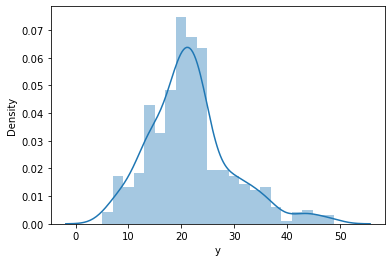

In [186]:
# let's remove outlier from y and check plot
reg_data_n = reg_data[reg_data['y']< 50]
print(f'We lost {len(reg_data) - len(reg_data_n)} observations')
sns.distplot(reg_data_n['y'])

Now let's use log transformation on var 13 and check relationship with

skeweness before is 0.9072987156990929 and after log transformation is -0.2613320150378225


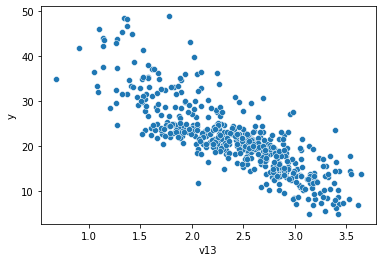

In [166]:
sns.scatterplot(np.log(reg_data_n['v13']), reg_data_n['y'], marker='o')
print(f"skeweness before is {reg_data_n['v13'].skew()} and after log transformation is {np.log(reg_data_n['v13']).skew()}")

In [197]:
# looks better
# let's log transform any other positively skewed var with unimode
for col in reg_data_n:
    if (reg_data_n[col].skew()>0.5 ) and (col not in ['v3','v4','v10','v9','y']) and (reg_data_n[col].min()>0):
        reg_data_n[col] = np.log(reg_data_n[col])
        print(col,reg_data_n[col].skew())

v1 0.4445201468902792
v5 0.38615486367080853
v8 0.15658070626222173
v13 -0.2613320150378225


<AxesSubplot:xlabel='v9', ylabel='y'>

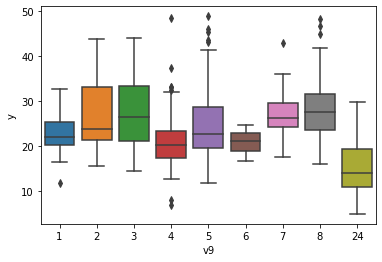

In [199]:
sns.boxplot(reg_data_n['v9'], reg_data['y'])

It seems that this var is having similar kind of values till 8 and seperate for 24 probably can use this as a categorical/dummy var

In [200]:
reg_data_n['v9'] = reg_data_n['v9'].apply(lambda x : 1 if x != 24 else 0)

<AxesSubplot:xlabel='v9', ylabel='y'>

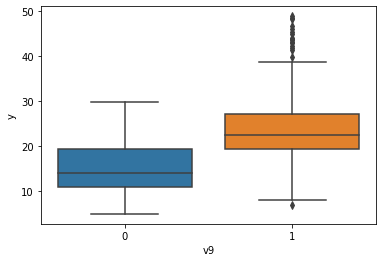

In [201]:
sns.boxplot(reg_data_n['v9'], reg_data['y'])

In [209]:
#Scaling the variables
def standard(X):
    mu=np.mean(X) 
    std=np.std(X) 
    sta=(X-mu)/std
    return sta

reg_data_f = pd.concat([standard(reg_data_n[list(set(reg_data_n.columns)-set(['v4','v9','y']))]),reg_data_n[['v4','v9','y']]],axis=1)
reg_data_f

,v5,v7,v6,v11,v8,v3,v10,v13,v1,v2,v12,v4,v9,y
0,-0.044162,-0.109432,0.505040,-1.527280,0.388790,-1.291856,-0.667101,-1.389952,-1.979504,0.301813,0.443535,0,1,24.0
1,-0.722803,0.377488,0.269017,-0.341504,0.752344,-0.593329,-0.988734,-0.333187,-1.300867,-0.486924,0.443535,0,1,21.6
2,-0.722803,-0.255152,1.439934,-0.341504,0.752344,-0.593329,-0.988734,-1.758311,-1.301207,-0.486924,0.399553,0,1,34.7
3,-0.840151,-0.798939,1.153335,0.085376,1.125153,-1.310933,-1.107857,-2.307128,-1.222048,-0.486924,0.419005,0,1,33.4
4,-0.840151,-0.500390,1.381694,0.085376,1.125153,-1.310933,-1.107857,-1.271749,-0.870751,-0.486924,0.443535,0,1,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.267467,0.029180,0.532627,1.176290,-0.548396,0.119873,-0.804093,-0.235089,-0.916002,-0.486924,0.390476,0,1,22.4
502,0.267467,0.299297,-0.192299,1.176290,-0.698529,0.119873,-0.804093,-0.344649,-1.066518,-0.486924,0.443535,0,1,20.6
503,0.267467,0.807542,1.119618,1.176290,-0.799358,0.119873,-0.804093,-1.173364,-0.930058,-0.486924,0.443535,0,1,23.9
504,0.267467,0.747121,0.840682,1.176290,-0.617369,0.119873,-0.804093,-0.931747,-0.656562,-0.486924,0.406253,0,1,22.0


#### Model iterations

In [210]:
# variable_list = reg_data_f.corr().abs()['y'].sort_values(ascending = False).to_frame().query("y>=0.5 and y !=1").index.to_list()
variable_list  =[x for x in reg_data_f.corr().abs()['y'].sort_values(ascending = False).index if x != 'y' ]
#Scaling the data
def rmse(predict,actual):
    return np.sqrt(np.mean(np.square(predict - actual)))

cols=[]
los_test=[]
los_train=[]
adj_r_sq=[]
y = reg_data_f['y']
i=0


while i < len(variable_list):
    cols.append(variable_list[i])
    X=reg_data_f[cols]
    
    #split the data and fitting model
    X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=3)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    reg_model=sm.OLS(y_train,X_train)
    reg_results = reg_model.fit()
    #Prediction on test and train
    pred_train=reg_results.predict(X_train)
    pred_test=reg_results.predict(X_test)
    
    #rmse on train and test
    loss_test=rmse(pred_test,y_test)
    loss_train=rmse(pred_train,y_train)
    los_train.append(loss_train)
    los_test.append(loss_test)
    
    #compute the adjusted r square
    adj_r_sq.append(reg_results.rsquared_adj)
    i+=1

In [216]:
for i in range(len(variable_list)):
    print(i+1,variable_list[i])

1 v13
2 v6
3 v3
4 v1
5 v10
6 v5
7 v11
8 v9
9 v7
10 v8
11 v2
12 v12
13 v4


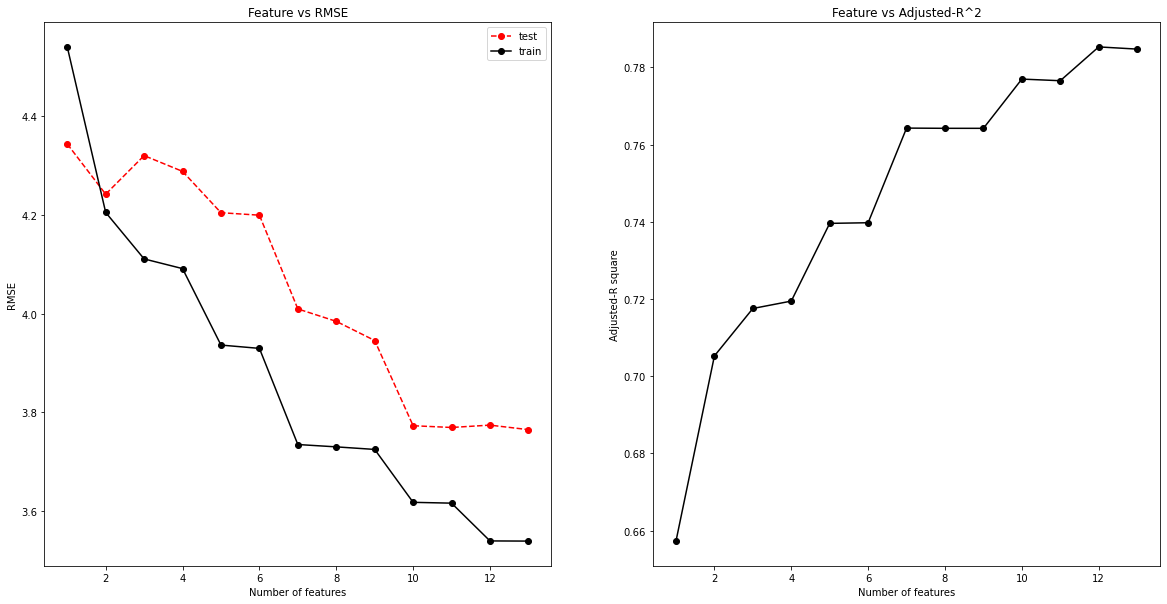

In [211]:
feature=np.arange(1,14)
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(20,10))
ax1.plot(feature,los_test,'r--o')
ax1.plot(feature,los_train,'k-o')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('RMSE')
ax1.legend(['test','train'])
ax1.set_title('Feature vs RMSE')
ax2.plot(feature,adj_r_sq,'k-o')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Adjusted-R square')
ax2.set_title('Feature vs Adjusted-R^2')
plt.show()

In the above charts we can see that that adding some of the var like 8th(v9) and 9th(v7) in our list are having very low/no impact. also test error doesn't decreases post 10th(v8).

Let's look at the p values for the betas

In [217]:
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     103.6
Date:                Mon, 03 Jan 2022   Prob (F-statistic):          7.67e-112
Time:                        23:11:58   Log-Likelihood:                -984.60
No. Observations:                 367   AIC:                             1997.
Df Residuals:                     353   BIC:                             2052.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.8539      0.942     24.250      0.000      21.000      24.707
v13           -3.5509      0.369     -9.611      0.000      -4.278      -2.824
v6             2.2704      0.272      8.357      0.000       1.736       2.805
v3            -0.3556      0.377     -0.943      0.347      -1.098       0.386
v1             0.4994      0.497      1.005      0.316      -0.478       1.477
v10           -1.7157      0.533     -3.218      0.001      -2.764      -0.667
v5            -1.3698      0.474     -2.890      0.004      -2.302      -0.438
v11           -1.6051      0.253     -6.350      0.000      -2.102      -1.108
v9            -1.7211      1.243     -1.385      0.167      -4.166       0.724
v7            -0.3051      0.355     -0.859      0.391      -1.004       0.393
v8            -1.8616      0.423     -4.397      0.000      -2.694      -1.029
v2            -0.1084      0.278     -0.390      0.697      -0.655       0.438
v12            0.8749      0.223      3.916      0.000       0.436       1.314
v4             0.2121      0.822      0.258      0.797      -1.405       1.829
==============================================================================
Omnibus:                       34.372   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.487
Skew:                           0.533   Prob(JB):                     2.22e-15
Kurtosis:                       4.810   Cond. No.                         21.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A look at the p values and coefficients tells that you can't reject hypothesis Beta = 0 for v1,v7, v3, v9, v2 and v4.Let's also look at updated correlation matrix

<AxesSubplot:>

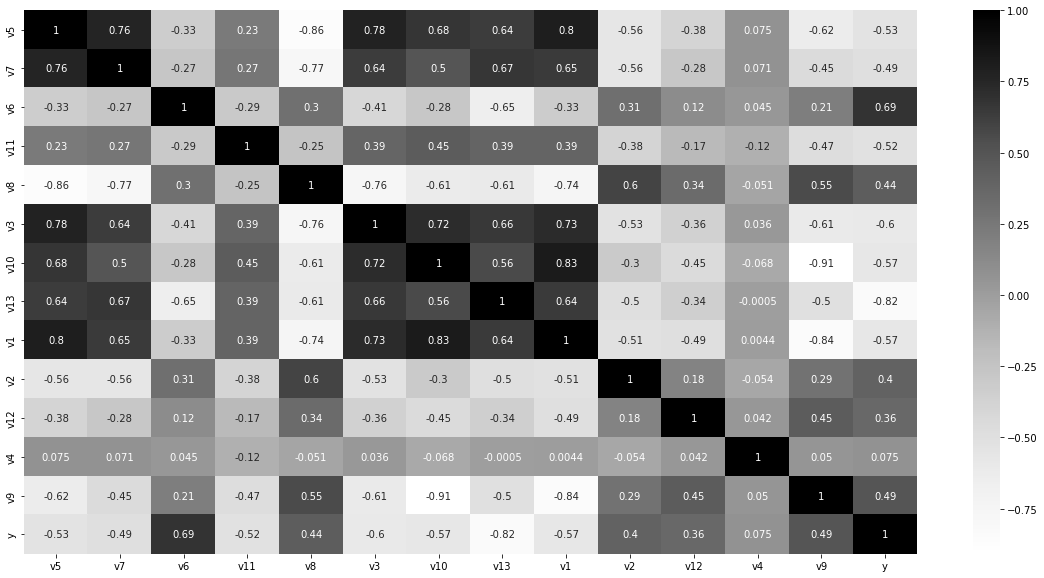

In [219]:
plt.figure(figsize=(20, 10))
sns.heatmap(reg_data_f.corr(),  annot=True,cmap='Greys')

This furher higlights the high multicollinearity like v1 and v10, v3 and v8.
let's check the model with only [v13,v6 and v3], [v13,v6 and v1] and [v13,v6 and v10] sepearately

In [257]:
def model_check(varlist):
    model = sm.OLS(y_train,sm.add_constant(X_train[varlist])).fit()
    print(f"rmse of model is {rmse(model.predict(sm.add_constant(X_train[varlist])),y_train)}")
    return model.summary()

In [258]:
model_check(['v13','v6','v3'])

rmse of model is 4.111236297502186


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     310.9
Date:                Tue, 04 Jan 2022   Prob (F-statistic):          6.51e-100
Time:                        00:09:30   Log-Likelihood:                -1039.6
No. Observations:                 367   AIC:                             2087.
Df Residuals:                     363   BIC:                             2103.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6344      0.216    100.193      0.000      21.210      22.059
v13           -4.1628      0.344    -12.088      0.000      -4.840      -3.486
v6             2.2581      0.283      7.974      0.000       1.701       2.815
v3            -1.1721      0.286     -4.104      0.000      -1.734      -0.610
==============================================================================
Omnibus:                       21.709   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.201
Skew:                           0.499   Prob(JB):                     1.24e-06
Kurtosis:                       3.886   Cond. No.                         2.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [259]:
model_check(['v13','v6','v1'])

rmse of model is 4.129054504858009


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     307.2
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           3.12e-99
Time:                        00:09:30   Log-Likelihood:                -1041.2
No. Observations:                 367   AIC:                             2090.
Df Residuals:                     363   BIC:                             2106.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6569      0.217     99.885      0.000      21.231      22.083
v13           -4.1439      0.360    -11.501      0.000      -4.852      -3.435
v6             2.4319      0.289      8.422      0.000       1.864       3.000
v1            -1.0534      0.286     -3.683      0.000      -1.616      -0.491
==============================================================================
Omnibus:                       32.469   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.725
Skew:                           0.610   Prob(JB):                     4.33e-11
Kurtosis:                       4.277   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [260]:
model_check(['v13','v6','v10'])

rmse of model is 3.9526690779570077


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     346.3
Date:                Tue, 04 Jan 2022   Prob (F-statistic):          4.16e-106
Time:                        00:09:30   Log-Likelihood:                -1025.2
No. Observations:                 367   AIC:                             2058.
Df Residuals:                     363   BIC:                             2074.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6339      0.208    104.224      0.000      21.226      22.042
v13           -3.7815      0.324    -11.673      0.000      -4.419      -3.144
v6             2.4687      0.274      9.006      0.000       1.930       3.008
v10           -1.7351      0.251     -6.923      0.000      -2.228      -1.242
==============================================================================
Omnibus:                       41.991   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.116
Skew:                           0.725   Prob(JB):                     4.40e-15
Kurtosis:                       4.490   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Building on the 3rd model

In [261]:
model_check(['v13','v6','v10','v5'])
# not significant imrovement

rmse of model is 3.94018049699446


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     261.2
Date:                Tue, 04 Jan 2022   Prob (F-statistic):          2.68e-105
Time:                        00:09:31   Log-Likelihood:                -1024.0
No. Observations:                 367   AIC:                             2058.
Df Residuals:                     362   BIC:                             2078.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6347      0.207    104.413      0.000      21.227      22.042
v13           -3.9819      0.349    -11.398      0.000      -4.669      -3.295
v6             2.4247      0.275      8.812      0.000       1.884       2.966
v10           -1.9529      0.288     -6.769      0.000      -2.520      -1.386
v5             0.4684      0.309      1.516      0.130      -0.139       1.076
==============================================================================
Omnibus:                       37.475   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.234
Skew:                           0.664   Prob(JB):                     2.26e-13
Kurtosis:                       4.430   Cond. No.                         3.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
model_check(['v13','v6','v10','v11'])

rmse of model is 3.750071127797172


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     297.8
Date:                Tue, 04 Jan 2022   Prob (F-statistic):          4.65e-113
Time:                        00:09:34   Log-Likelihood:                -1005.8
No. Observations:                 367   AIC:                             2022.
Df Residuals:                     362   BIC:                             2041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6258      0.197    109.660      0.000      21.238      22.014
v13           -3.6794      0.308    -11.939      0.000      -4.285      -3.073
v6             2.3036      0.262      8.802      0.000       1.789       2.818
v10           -1.1753      0.254     -4.627      0.000      -1.675      -0.676
v11           -1.4602      0.230     -6.338      0.000      -1.913      -1.007
==============================================================================
Omnibus:                       41.669   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.327
Skew:                           0.716   Prob(JB):                     3.96e-15
Kurtosis:                       4.512   Cond. No.                         2.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Final Model

In [263]:
# adding v7 hypothesis test of v7 failed
model_check(['v13','v6','v10','v11','v8'])

rmse of model is 3.69909486451274


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     246.1
Date:                Tue, 04 Jan 2022   Prob (F-statistic):          6.19e-114
Time:                        00:09:37   Log-Likelihood:                -1000.8
No. Observations:                 367   AIC:                             2014.
Df Residuals:                     361   BIC:                             2037.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6327      0.195    111.046      0.000      21.250      22.016
v13           -4.0533      0.327    -12.413      0.000      -4.696      -3.411
v6             2.2197      0.260      8.541      0.000       1.709       2.731
v10           -1.5673      0.280     -5.602      0.000      -2.117      -1.017
v11           -1.3413      0.231     -5.815      0.000      -1.795      -0.888
v8            -0.8622      0.272     -3.165      0.002      -1.398      -0.326
==============================================================================
Omnibus:                       30.952   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.705
Skew:                           0.576   Prob(JB):                     7.21e-11
Kurtosis:                       4.314   Cond. No.                         3.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I am going with final model keeping this variables ['v13','v6','v10','v11','v8'] all the cariables after this are having quite low correalation with y and probably already captured by earlier variables. 

#### Test Stats

In [271]:
final_model = sm.OLS(y_train,sm.add_constant(X_train[['v13','v6','v10','v11','v8']])).fit()

In [276]:
test_pred=final_model.predict(sm.add_constant(X_test[['v13','v6','v10','v11','v8']]))
# R_square 
sse = np.sum((test_pred - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Root Mean Square Error(MSE) of test is: ',rmse(test_pred,y_test))
print('R square obtain for test is :',R_square)

The Root Mean Square Error(MSE) of test is:  3.8739993639236316
R square obtain for test is : 0.771996479978681


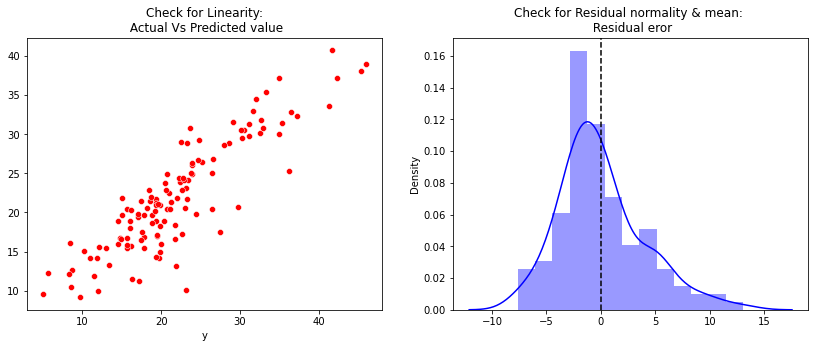

In [277]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,test_pred,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - test_pred),ax=ax,color='b')
ax.axvline((y_test - test_pred).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

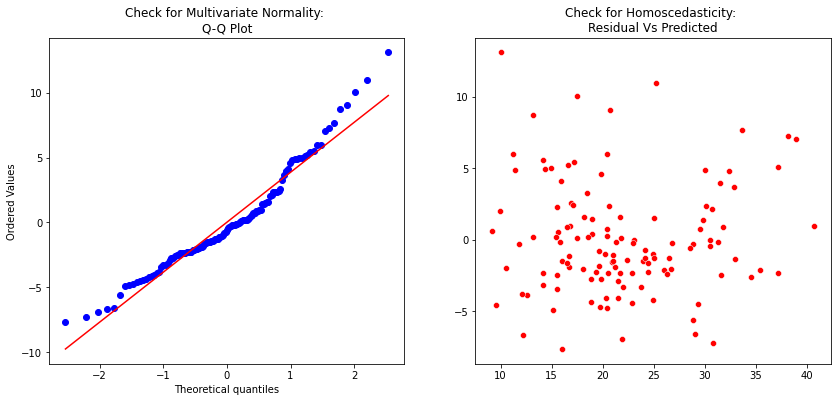

In [278]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - test_pred),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - test_pred), x= test_pred, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');